## Predicting Churn for a Telecommunications Company

The following notebook uses data from [Using Customer Behavior Data to Improve Customer Retention – IBM Analytics Communities](https://www.ibm.com/communities/analytics/watson-analytics-blog/predictive-insights-in-the-telco-customer-churn-data-set/). This is the Capstone Project for my Machine Learning Nanodegree from Udacity.

###Importing libraries

In [311]:
#Import necessary libraries
import pandas as pd
import numpy as np
import sklearn

#Prepare to plot
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#Diplay
from IPython.display import display

###Data Exploration

In [330]:
data = pd.read_csv("../data/dataset.csv", delimiter=";", decimal=",", thousands=None)

In [331]:
data.describe().columns.values

array(['SeniorCitizen', 'tenure', 'MonthlyCharges'], dtype=object)

#### Cleaning Data

In [332]:
#Check if data has null values
data.isnull().values.sum()

0

In [333]:
#Check if there are empty Strings in any column of type column
for col in data.columns.values:
    if data[col].dtype == object:
        print str(col)+' :'+str(len(data[data[col]==' ']))

customerID :0
gender :0
Partner :0
Dependents :0
PhoneService :0
MultipleLines :0
InternetService :0
OnlineSecurity :0
OnlineBackup :0
DeviceProtection :0
TechSupport :0
StreamingTV :0
StreamingMovies :0
Contract :0
PaperlessBilling :0
PaymentMethod :0
TotalCharges :11
Churn :0


In [334]:
#Replace empty Strings of TotalCharges with Mode
data = data.replace(' ', '20,20', regex=False)

In [335]:
#Transoform TotalCharges column to float
data['TotalCharges'] = data['TotalCharges'].apply(lambda x: float(str(x).replace(',','.')))

#### Finding Outliers for numerical variables

In [292]:
#Identify if there are any outliers
from collections import Counter

c = Counter()

# For each feature find the data points with extreme high or low values
for col in data.columns.values:
    #do only for numerical variables
    if data[str(col)].dtype != object and str(col) != 'SeniorCitizen':
    
        # Calculate Q1 (25th percentile of the data) for the given feature
        Q1 = np.percentile(data[str(col)], 25)

        # Calculate Q3 (75th percentile of the data) for the given feature
        Q3 = np.percentile(data[str(col)], 75)

        # Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
        step = 1.5*(Q3-Q1)

        # Display the outliers
        print "Data points considered outliers for the feature '{}':".format(str(col))
        display(data[~((data[str(col)] >= Q1 - step) & (data[str(col)] <= Q3 + step))])

Data points considered outliers for the feature 'tenure':


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn


Data points considered outliers for the feature 'MonthlyCharges':


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn


Data points considered outliers for the feature 'TotalCharges':


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn


###Data Visualization

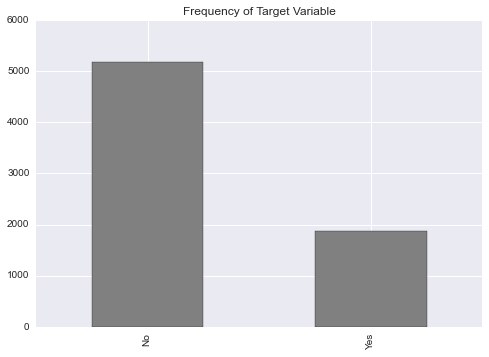

In [9]:
data['Churn'].value_counts().plot(kind='bar', color='grey', title='Frequency of Target Variable')

In [14]:
#Extract only categorical columns
categorical = data.copy()

for col in data.columns.values:
    if data[col].dtype != object or str(col) in  ['customerID']:
        categorical.drop(str(col), axis = 1, inplace=True)

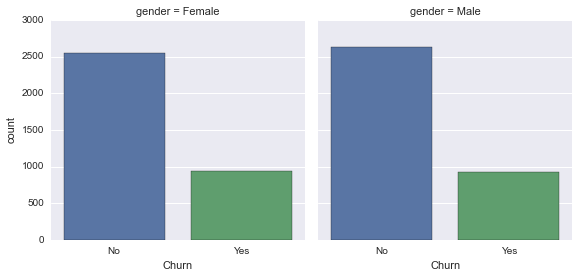

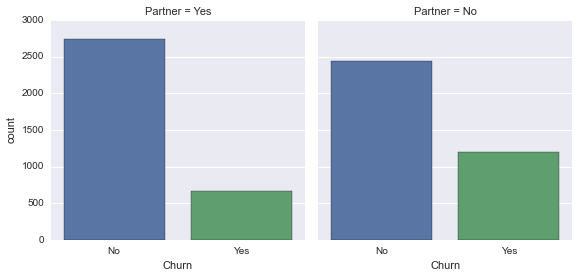

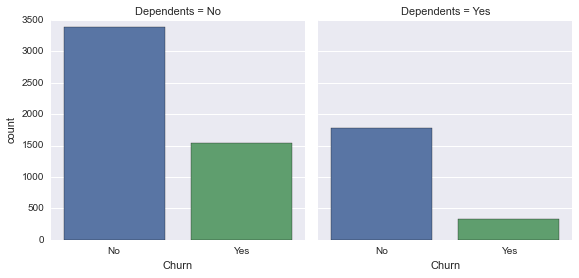

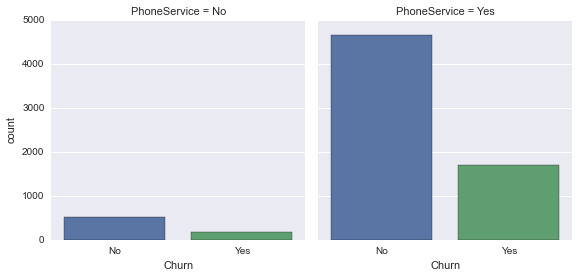

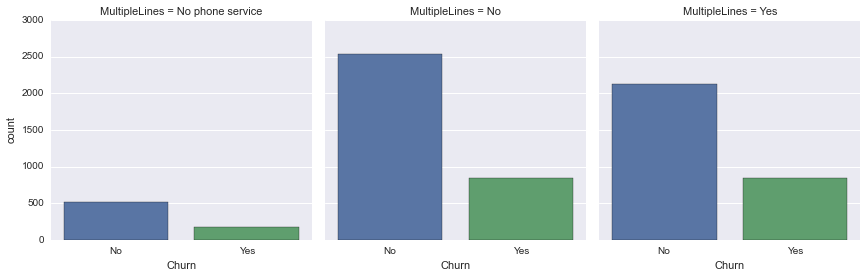

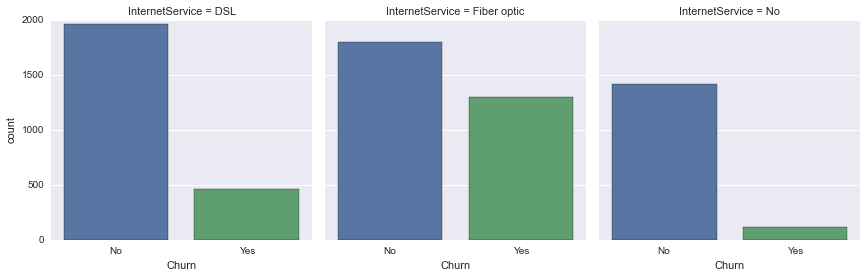

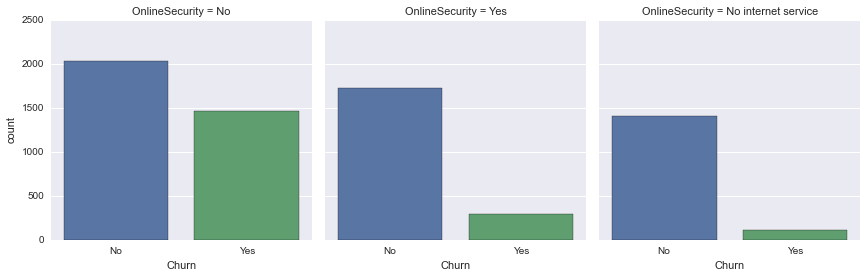

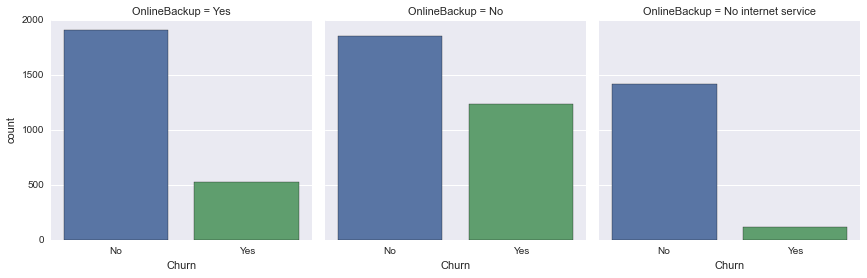

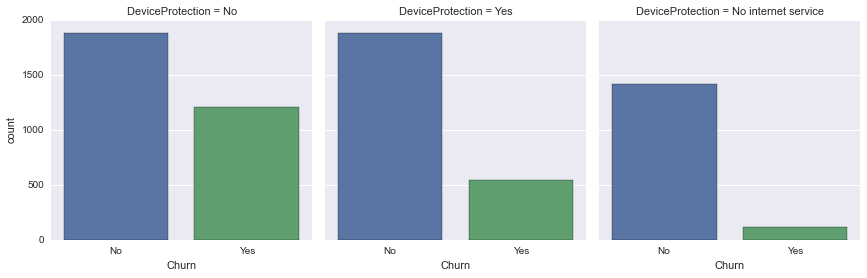

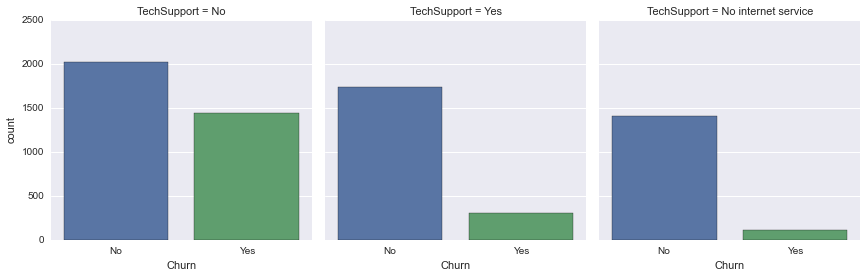

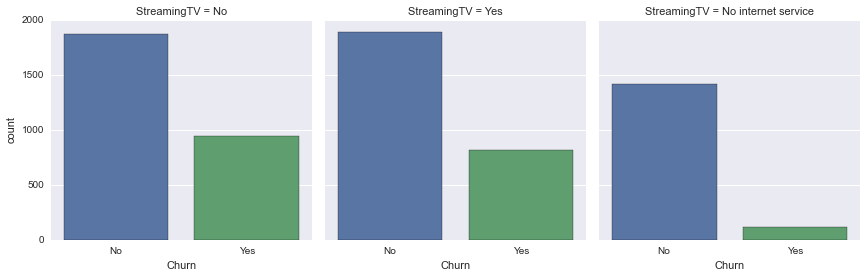

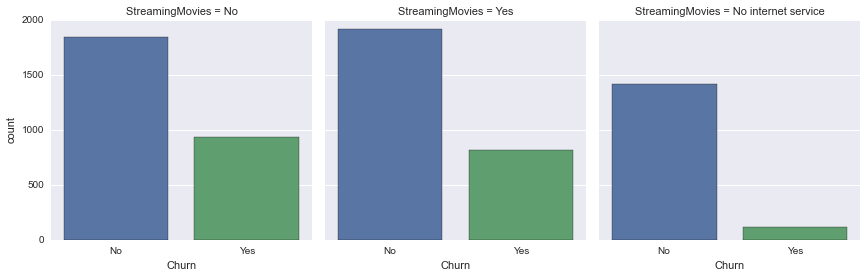

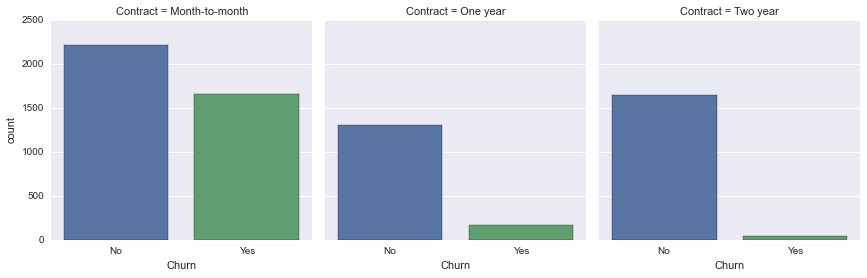

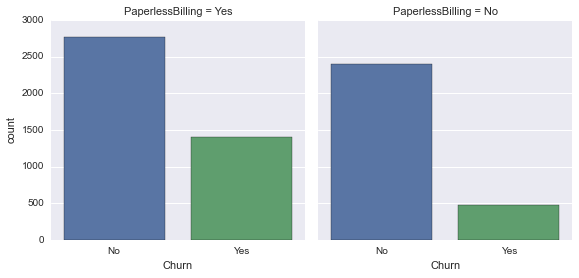

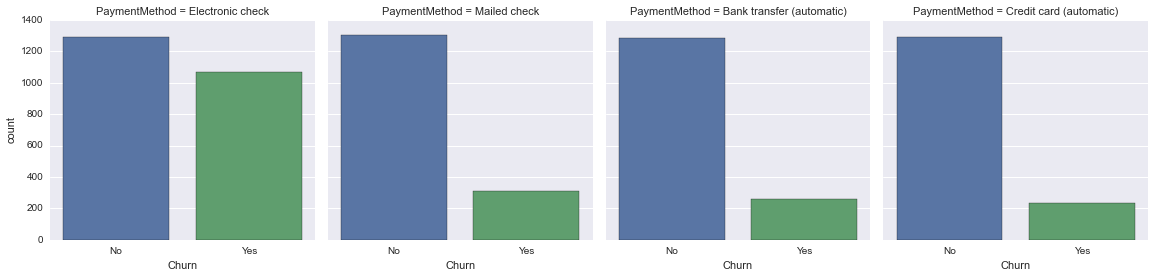

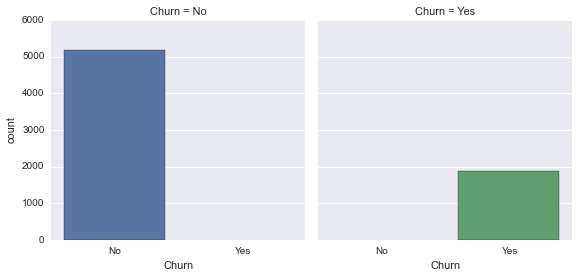

In [15]:
#plot distribiution of 'Subscription variable' for all categorical variables
for column in categorical.columns.values:
    sns.factorplot('Churn', col=str(column), data=categorical, kind="count")

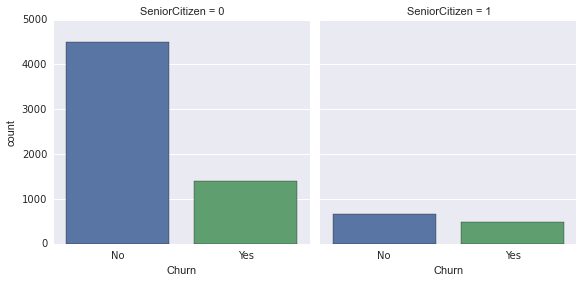

In [419]:
sns.factorplot('Churn', col='SeniorCitizen', data=data, kind="count")

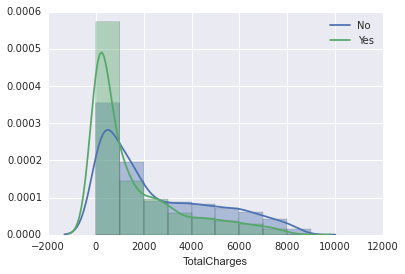

In [420]:
for value in data.Churn.value_counts().keys():
    sns.distplot(data['TotalCharges'][(data['TotalCharges'] != np.nan) & (data['Churn'] == value)], kde_kws={'label':str(value)}, bins=[0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000])

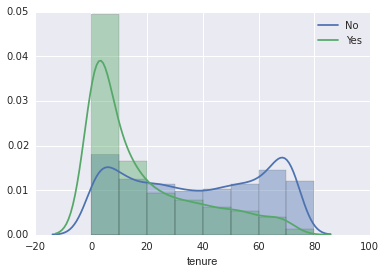

In [421]:
for value in data.Churn.value_counts().keys():
    sns.distplot(data['tenure'][data['Churn'] == value], norm_hist=False, kde_kws={'label':str(value)}, bins=[0,10,20,30,40,50,60,70,80])

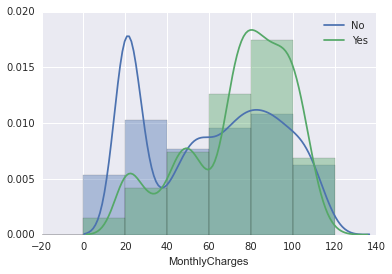

In [422]:
for value in data.Churn.value_counts().keys():
    sns.distplot(data['MonthlyCharges'][data['Churn'] == value], kde_kws={'label':str(value)}, bins=[-20,0,20,40,60,80,100,120])

### Data Preprocessing

In [336]:
#Shuffle Datafram to make sure any sorting doesn't impact test and train sets later
from sklearn.utils import shuffle

data = shuffle(data)

#Target column
target = data['Churn'].replace(['Yes', 'No'], [1, 0])

#Feature Columns
features = data.drop('Churn', axis=1)

In [337]:
def preprocess_features(X):
    ''' Converts non-numeric binary variables into binary (0/1) variables. Converts categorical variables into dummy variables.'''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():
        
        # If data type is non-numeric, replace all yes/no values with 1/0
        if col_data.dtype == object and str(col) == 'gender':
            col_data = col_data.replace(['Female', 'Male'], [1, 0])
            
        # If data type is non-numeric, replace all yes/no values with 1/0
        if col_data.dtype == object and str(col) in ['Partner','Dependents','PhoneService', 'PaperlessBilling']:
            col_data = col_data.replace(['Yes', 'No'], [1, 0])

        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object and str(col) != 'customerID' and str(col) not in ['Partner','Dependents','PhoneService', 'PaperlessBilling']:
            col_data = pd.get_dummies(col_data, prefix = col)  
        
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

X_all = preprocess_features(features)
print "Processed feature columns ({} total features):\n{}".format(len(X_all.columns), list(X_all.columns))

Processed feature columns (41 total features):
['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines_No', 'MultipleLines_No phone service', 'MultipleLines_Yes', 'InternetService_DSL', 'InternetService_Fiber optic', 'InternetService_No', 'OnlineSecurity_No', 'OnlineSecurity_No internet service', 'OnlineSecurity_Yes', 'OnlineBackup_No', 'OnlineBackup_No internet service', 'OnlineBackup_Yes', 'DeviceProtection_No', 'DeviceProtection_No internet service', 'DeviceProtection_Yes', 'TechSupport_No', 'TechSupport_No internet service', 'TechSupport_Yes', 'StreamingTV_No', 'StreamingTV_No internet service', 'StreamingTV_Yes', 'StreamingMovies_No', 'StreamingMovies_No internet service', 'StreamingMovies_Yes', 'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year', 'PaperlessBilling', 'PaymentMethod_Bank transfer (automatic)', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check', '

In [117]:
#Set customerID as index
#X_all.index = X_all.customerID

In [338]:
#Drop customerID and all redundant 6 columns for 'No internet service' and 1 for 'No phone service' 
X_all.drop(['customerID','MultipleLines_No phone service','OnlineSecurity_No internet service','OnlineBackup_No internet service','DeviceProtection_No internet service','TechSupport_No internet service', 'StreamingTV_No internet service','StreamingMovies_No internet service'],axis=1, inplace=True)

In [339]:
#List for selecting numerical features
numerical_vars = ['tenure','MonthlyCharges', 'TotalCharges']

#Normalizing Categorical variables
X_all[numerical_vars] = (X_all[numerical_vars] - X_all[numerical_vars].mean()) / (X_all[numerical_vars].max() - X_all[numerical_vars].min())

### Implementation

1. Training and Testing Data

In [340]:
# train_test_split splits data into **random** train and test subsets
from sklearn.cross_validation import train_test_split

# Shuffle and split the dataset into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X_all, target, random_state=40, test_size=3043, stratify=target)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 4000 samples.
Testing set has 3043 samples.


### Models

In [341]:
### Import needed packages
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import precision_recall_fscore_support
from sklearn.svm import LinearSVC
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score

# Define a random state to seed your algorithms
ran_state = 40

# Define your classifier
clf = LinearSVC(random_state=ran_state)

# Create the parameters list you wish to tune
parameters = { 'C' : [1], #5,10,100 were also tested
              'tol': [0.0001],# 0.001, 0.01 and 0.1 were also tested as values
              'class_weight': [{1:2}]} #1:3, 1:5 and 1:10 were also tested

# Create scorer
score = make_scorer(f1_score, average='binary', pos_label=1)

# Create a grid search object
grid_obj = GridSearchCV(clf, param_grid=parameters, scoring=score,
                       cv=10)

# Fit the grid search object to the training data and find the optimal parameters
grid_obj.fit(X_train, y_train)

# Get the estimator
clf = grid_obj.best_estimator_

# Print the parameters
print clf.get_params(), '\n'

# Predict
train_pred = clf.predict(X_train)
test_pred = clf.predict(X_test)

{'loss': 'squared_hinge', 'C': 1, 'verbose': 0, 'intercept_scaling': 1, 'fit_intercept': True, 'max_iter': 1000, 'penalty': 'l2', 'multi_class': 'ovr', 'random_state': 40, 'dual': True, 'tol': 0.0001, 'class_weight': {1: 2}} 



### Oversampling

In [273]:
indexes_robustness = y_test[y_test == 0].index

In [274]:
#Change diff to try different balanced test sets, for instance, substractor = 808 would yield a 50/50 distribution
substractor = 269
diff =  2235 - substractor
indexes_drop = X_test.loc[indexes_robustness].head(diff).loc()

In [275]:
X_test = X_test.drop(X_test.loc[indexes_drop.obj.index].index)

In [276]:
y_test = y_test.drop(y_test.loc[indexes_drop.obj.index].index)

### Undersampling

In [246]:
indexes_robustness = y_test[y_test == 1].index

In [247]:
substractor = 117
diff =  808 - substractor
indexes_drop = X_test.loc[indexes_robustness].head(diff).loc()

In [248]:
X_test = X_test.drop(X_test.loc[indexes_drop.obj.index].index)

In [249]:
y_test = y_test.drop(y_test.loc[indexes_drop.obj.index].index)

### Scores

In [342]:
# Predict
train_pred = clf.predict(X_train)
test_pred = clf.predict(X_test)

# Report the final F1 score for training and testing after parameter tuning
print "Tuned model has a training scores of " +str(precision_recall_fscore_support(y_train, train_pred, average='binary', pos_label=1))
print "Tuned model has a testing scores of "+str(precision_recall_fscore_support(y_test, test_pred, average='binary', pos_label=1))

Tuned model has a training scores of (0.55846917080085046, 0.74269557021677668, 0.63754045307443363, None)
Tuned model has a testing scores of (0.5536205316223648, 0.74752475247524752, 0.63612427593470244, None)


In [92]:
#with stratify and with class weight
results_train_ww = [0.638, 0.642, 0.642, 0.637, 0.640, 0.639]
results_test_ww = [0.628, 0.625, 0.630, 0.635, 0.634, 0.632]

In [93]:
#without stratify with class weight
results_train_nw = [0.632, 0.640, 0.644, 0.645, 0.641, 0.643]
results_test_nw = [0.623, 0.627, 0.625, 0.624, 0.623, 0.590]
x = [x * 1000 for x in range(1,7)]

In [94]:
#with stratify without class_weight
results_train_wn = [0.591, 0.606, 0.595, 0.602, 0.590, 0.595]
results_test_wn = [0.568, 0.573, 0.587, 0.586, 0.608, 0.589]

In [95]:
#withouth stratify without class_weight
results_train_nn = [0.534, 0.605, 0.614, 0.607, 0.596, 0.602]
results_test_nn = [0.551, 0.598, 0.591, 0.589, 0.598, 0.555]

### Benchmark

In [280]:
def predictions_watson(data):
    """ Benchmark model described in report """
    
    predictions = []
    for _, customer in data.iterrows():
        
        if (customer['Contract_Month-to-month'] == 1) and (customer['InternetService_Fiber optic'] == 1) and (customer['MultipleLines_Yes'] == 1) and (customer['TotalCharges'] <= 266.43) and (customer['tenure'] <= 6):
            predictions.append(1) 
        else:
            predictions.append(0)
    
    # Return our predictions
    return pd.Series(predictions)

In [296]:
# Make the predictions, remeber to reset data as numeric variables should not be normalized
predictions_bm = predictions_watson(X_all)

In [297]:
#Get recall score
print precision_recall_fscore_support(target, predictions_bm, average='binary', pos_label=1)

(0.85833333333333328, 0.055109684323167471, 0.10356963298139769, None)


In [299]:
bench = X_all[(X_all['Contract_Month-to-month'] == 1) & (X_all['InternetService_Fiber optic'] == 1) & (X_all['MultipleLines_Yes'] == 1) & (X_all['TotalCharges'] <= 266.43) & (X_all['tenure'] <= 6)]

In [300]:
target[bench.index].value_counts()

1    103
0     17
dtype: int64

In [301]:
predictions_bm.value_counts()

0    6923
1     120
dtype: int64

In [72]:
exc = target.index.isin(np.array(bench.index))

In [73]:
target[~exc].value_counts()

0    5157
1    1766
dtype: int64